# Pump It Up Data Mining the Water Table

# Content:
1. [Introduction](#first-bullet)
2. [Data Overview](#second-bullet)
    * [Loading Datasets](#second1-bullet)
    * [Changing Data Type](#second2-bullet)
    * [Data Exploration](#second3-bullet)
        * [Dataset Profile](#second31-bullet)
* [Data Cleaning](#third-bullet)
    * [Handeling Outliers](#third1-bullet)
    * [Handeling Missing Values](#third2-bullet)
    * [Checking Correlations]
    * [Removing Irrelevant Variables]
    * [Data Transfomations]
* [Feature Engineering]
    * [PCA]
* [Modeling]
    * [LDA]
    * [Baseline Model]

* `[The Pipeline](#fifth-bullet)


## 1. Introduction <a class="anchor" id="first-bullet"></a>

## 2. Data Overview 

   ### 2.1. Loading Datasets <a class="anchor" id="second1-bullet"></a>

In [10]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


In [11]:
training_label = pd.read_csv("data/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
training_values = pd.read_csv("data/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
test = pd.read_csv("data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")

train = training_values.merge(training_label, on = 'id')


test['status_group'] = '*unknown*'#the unknown target variable

#We will annotate our train and test set before combining them for simple indexing later on. 
train['data_set'] = 'train'
test['data_set'] = 'test'

trainset = pd.DataFrame(train)
testset = pd.DataFrame(test)

display(Markdown("There are {} observations in training set, and {} observations in the test set:{} in total".format(len(train), len(test), len(train) + len(test))))
display(Markdown("There are {} variables in training dataset including the target variable.".format(len(train.columns))))

There are 59400 observations in training set, and 14850 observations in the test set:74250 in total

There are 42 variables in training dataset including the target variable.

In [12]:
display(Markdown("Combining test and train set.")) 
dataset = trainset.append(testset)
dataset.head()

Combining test and train set.

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... quality_group  \
0  34.938093  -9.856322                  none            0  ...          good   
1  34.698766  -2.147466              Zahanati            0  ...          good   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          good   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          good   
4  31.130847  -1.825359               Shuleni            0  ...          good   

       quantity quantity_group                source           source_type  \
0        enough         enough                spring                spring   
1  insufficient   insufficient  rainwater harvesting  rainwater harvesting   
2        enough         enough                   dam                   dam   
3           dry            dry           machine dbh              borehole   
4      seasonal       seasonal  rainwater harvesting  rainwater harvesting   

  source_class              waterpoint_type  waterpoint_type_group  \
0  groundwater           communal standpipe     communal standpipe   
1      surface           communal standpipe     communal standpipe   
2      surface  communal standpipe multiple     communal standpipe   
3  groundwater  communal standpipe multiple     communal standpipe   
4      surface           communal standpipe     communal standpipe   

     status_group data_set  
0      functional    train  
1      functional    train  
2      functional    train  
3  non functional    train  
4      functional    train  

[5 rows x 42 columns]

In [13]:
dataset[:59400].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

### 2.2. Data Type <a class="anchor" id="second2-bullet"></a>

The data loaded recognized numeric and object variable in our dataset. We need to change these to categories and also change other variables which are defined as numbers into categories. 

In [14]:
#Changing datatypes from Objects to Categories.
for col in dataset:
    if dataset.dtypes[col].name == 'object':
        dataset[col] = dataset[col].astype('category')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 42 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null category
funder                   69746 non-null category
gps_height               74250 non-null int64
installer                69718 non-null category
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null category
num_private              74250 non-null int64
basin                    74250 non-null category
subvillage               73780 non-null category
region                   74250 non-null category
region_code              74250 non-null int64
district_code            74250 non-null int64
lga                      74250 non-null category
ward                     74250 non-null category
population               74250 non-null int64
public_meeting           70095

In [15]:
#Setting other varaibles defined as numbers to categories. 
other_categoricals = ['id', 'district_code', 'construction_year', 'region_code', 'longitude', 'latitude'] #removed gps_height
dataset[other_categoricals] = dataset[other_categoricals].astype('category')

### 2.3. Data Exploration <a class="anchor" id="second3-bullet"></a>

##### Dataset Profile <a class="anchor" id="second31-bullet"></a>

The profile of training set in our dataset highlights key aspects of our data, including correlations, missing values, and distribution. We will further explore the variables one by one below. 

In [16]:
profile = ProfileReport(trainset,title='Training Dataset Summary Report', html={'style':{'full_width':True}})

In [8]:
profile.to_notebook_iframe()

#### Status Group

In [17]:
dataset["status_group"].value_counts()

functional                 32259
non functional             22824
*unknown*                  14850
functional needs repair     4317
Name: status_group, dtype: int64

The classes in our train set is unbalanced as we have very small proportion for 'Functional Needs Repair'. We will try upsample and undersample method later on to fix this issue.

#### Check Null Values

In [18]:
dataset.isna().sum()[dataset.isna().sum().ne(0)]

funder                4504
installer             4532
subvillage             470
public_meeting        4155
scheme_management     4846
scheme_name          35258
permit                3793
dtype: int64

We have 7 variables ('funder', 'installer', 'subvillage','public_meeting', 'public_meeting', 'scheme_management', 'scheme_name', 'permit') with missing values. 
However, the dataset profile shows there are variables below that have zeros:
    - "amount_sth"
    - "population"
    - "gps_height"
    - "construction_year"

Text(0.5, 1.0, 'Population Around the Well')

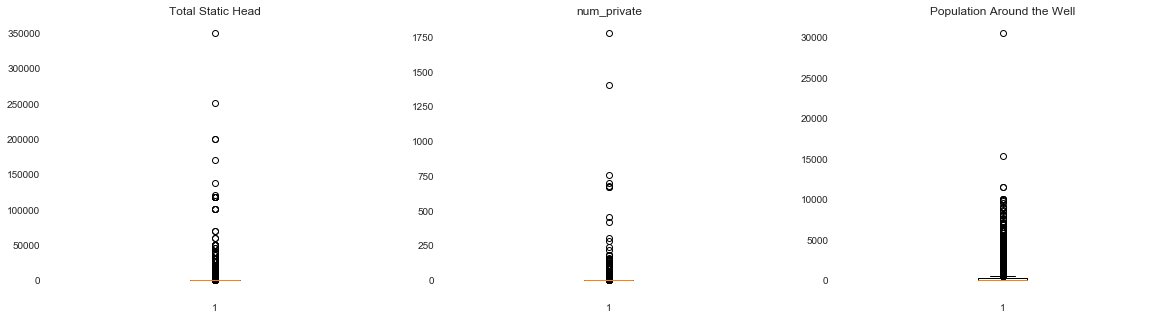

In [19]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))

axs[0].boxplot(dataset['amount_tsh'])
axs[0].set_title('Total Static Head')
axs[1].boxplot(dataset['num_private'])
axs[1].set_title('num_private')
axs[2].boxplot(dataset['population'])
axs[2].set_title('Population Around the Well')

In [20]:
dataset.describe()

amount_tsh    gps_height   num_private    population
count   74250.000000  74250.000000  74250.000000  74250.000000
mean      318.685704    665.667313      0.462330    180.750828
std      2906.762364    692.761033     11.537879    471.086120
min         0.000000    -90.000000      0.000000      0.000000
25%         0.000000      0.000000      0.000000      0.000000
50%         0.000000    364.000000      0.000000     25.000000
75%        20.000000   1317.000000      0.000000    215.000000
max    350000.000000   2777.000000   1776.000000  30500.000000

Text(0.5, 0.98, '')

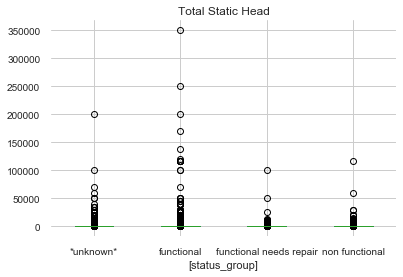

In [21]:
axes = dataset.boxplot(column=['amount_tsh'],by=['status_group']).set_title('Total Static Head')
fig = axes.get_figure()
fig.suptitle('')

There are alot of '0' values for amount of static head for working pumps which is an error. We will change this values to NaN and impute them as missing values. This is becuase it is not possible to have **'functional'** and **'functional needs repair'** pumps with zero value for static head.

There is no clear definition of what **num_private** means and 99% of the observations are zero thus we can ignore it from our model.

#### Checking Duplicates

We have no duplicated rows in our dataset.

In [22]:
dataset[dataset["id"].duplicated()]

Empty DataFrame
Columns: [id, amount_tsh, date_recorded, funder, gps_height, installer, longitude, latitude, wpt_name, num_private, basin, subvillage, region, region_code, district_code, lga, ward, population, public_meeting, recorded_by, scheme_management, scheme_name, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group, status_group, data_set]
Index: []

[0 rows x 42 columns]

## 3. Data Cleaning <a class="anchor" id="third-bullet"></a>

Following the finding above we will change the variables with zeros empty values below.   
- "amount_tsh"
- "population"
- "gps_height"
- "construction_year"
After the replacement the below is the actual missing values we have in the 74,250 observations we have to impute. 

In [23]:
zero_cols = ['amount_tsh','population','gps_height','construction_year']
dataset[zero_cols] = dataset[zero_cols].replace({'0':np.nan, 0:np.nan})

In [24]:
dataset.isna().sum()[dataset.isna().sum().ne(0)]

amount_tsh           52049
funder                4504
gps_height           25649
installer             4532
subvillage             470
population           26834
public_meeting        4155
scheme_management     4846
scheme_name          35258
permit                3793
construction_year    25969
dtype: int64

Below we substring **date_recorded** to get **year_recorded** and then change the data type for **date_recorded** from catgory to date.

In [62]:
dataset['year_recorded'] = dataset['date_recorded'].str[:4]

AttributeError: Can only use .str accessor with string values!

In [63]:
dataset["date_recorded"] = dataset["date_recorded"].astype('datetime64[ns]') 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 42 columns):
id                       74250 non-null category
amount_tsh               22201 non-null float64
date_recorded            74250 non-null datetime64[ns]
funder                   69746 non-null category
gps_height               48601 non-null float64
installer                69718 non-null category
longitude                74250 non-null category
latitude                 74250 non-null category
wpt_name                 74250 non-null category
basin                    74250 non-null category
subvillage               73780 non-null category
region                   74250 non-null category
region_code              74250 non-null category
district_code            74250 non-null category
lga                      74250 non-null category
ward                     74250 non-null category
population               47416 non-null float64
public_meeting           70095 non-null category
record

We will also remove the variable **num_private** as 99% of the observations are zero and there no discription of what this varible means, imputing it or explaining our model even if we find meaningful relationship would be impossible. 

In [52]:
dataset=dataset.drop(columns=['num_private'])
dataset.shape

(74250, 42)

### 3.1. Outliers <a class="anchor" id="third1-bullet"></a>

Before imputing the missing values, first the outliers will be checked excluding the missing values to make sure don impute based on them. 

In [53]:
dataset.describe()

amount_tsh    gps_height    population  construction_year
count   22201.000000  48601.000000  47416.000000       48281.000000
mean     1065.826474   1016.970803    283.042623        1996.870943
std      5240.480449    613.127399    564.413842          12.440524
min         0.200000    -90.000000      1.000000        1960.000000
25%        50.000000    390.000000     40.000000        1988.000000
50%       250.000000   1166.000000    150.000000        2000.000000
75%      1000.000000   1497.000000    328.000000        2008.000000
max    350000.000000   2777.000000  30500.000000        2013.000000

In [92]:
nonan_dataset1=dataset[dataset['amount_tsh'].notna()]
nonan_dataset2=dataset[dataset['gps_height'].notna()]
nonan_dataset3=dataset[dataset['population'].notna()]

[format(len(dataset)),format(len(nonan_dataset1)), format(len(nonan_dataset2)),format(len(nonan_dataset3))]

['74250', '22201', '48601', '47416']

Text(0.5, 1.0, 'Population Around the Well')

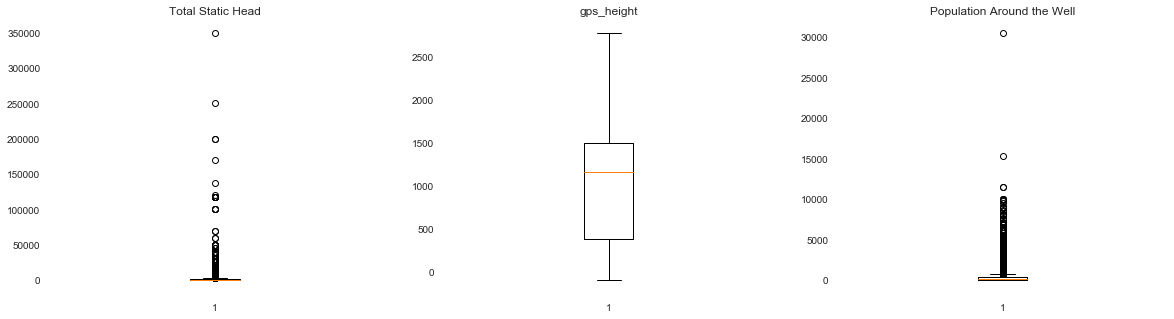

In [81]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))


axs[0].boxplot(nonan_dataset1['amount_tsh'])
axs[0].set_title('Total Static Head')
axs[1].boxplot(nonan_dataset2['gps_height'])
axs[1].set_title('gps_height')
axs[2].boxplot(nonan_dataset3['population'])
axs[2].set_title('Population Around the Well')

In [102]:
sub_dataset=dataset[['amount_tsh','population']]
Q1 = sub_dataset.quantile(0.25)
Q3 = sub_dataset.quantile(0.75)
IQR = Q3 - Q1

((sub_dataset < (Q1 - 1.5 * IQR)) | (sub_dataset > (Q3 + 1.5 * IQR))).sum()

amount_tsh    2058
population    3105
dtype: int64

We don't have enough information regarding the total static head and what would be regarded as the maximum amount thus we can not assume that these values are errors. Similarly, with population surrounding the well could go as high as 30000 so we don't have enough justification with the amount of missing values that we have to regard these as outliers or errors. 

With binning we can create categories for this values so that out model can train and predict on them in the cases that they do come up. 

### 3.2. Missing Values <a class="anchor" id="third2-bullet"></a>

In [125]:
missing_val=pd.DataFrame()
missing_val['proportion']=pd.DataFrame(dataset.isna().sum()[dataset.isna().sum().ne(0)])

In [126]:
missing_val['missing count']=missing_val[0]
missing_val['proportion']=missing_val['missing count']/74250*100
missing_val

0  missing count  proportion
amount_tsh         52049          52049   70.099663
funder              4504           4504    6.065993
gps_height         25649          25649   34.544108
installer           4532           4532    6.103704
subvillage           470            470    0.632997
population         26834          26834   36.140067
public_meeting      4155           4155    5.595960
scheme_management   4846           4846    6.526599
scheme_name        35258          35258   47.485522
permit              3793           3793    5.108418
construction_year  25969          25969   34.975084